#load dataset

In [ ]:
# Load dataset and basic check
import pandas as pd

def load_semicolon_file(path):
    texts, labels = [], []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if ';' in line:
                text, label = line.rsplit(';', 1)
                texts.append(text.strip())
                labels.append(label.strip())
            else:
                texts.append(line)
                labels.append('unknown')
    return pd.DataFrame({'text': texts, 'label': labels})

train_path = '/content/train.txt'
val_path   = '/content/val.txt'
test_path  = '/content/test.txt'

df_train = load_semicolon_file(train_path)
df_val   = load_semicolon_file(val_path)
df_test  = load_semicolon_file(test_path)

print("Train:", df_train.shape, "Val:", df_val.shape, "Test:", df_test.shape)
df_train.head()

Train: (16000, 2) Val: (2000, 2) Test: (2000, 2)


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


#explore the dataset

Label distribution:
 label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Sample texts:
 ['ive made it through a week i just feel beaten down', 'i feel this strategy is worthwhile', 'i feel so worthless and weak what does he have to say that s what i want to find out']


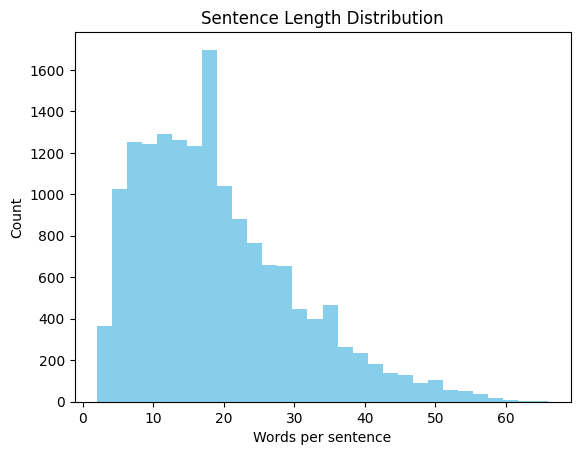

In [ ]:
# Simple exploration
import matplotlib.pyplot as plt

print("Label distribution:\n", df_train['label'].value_counts())
print("\nSample texts:\n", df_train['text'].sample(3, random_state=42).tolist())

df_train['length'] = df_train['text'].apply(lambda x: len(x.split()))
plt.hist(df_train['length'], bins=30, color='skyblue')
plt.title("Sentence Length Distribution")
plt.xlabel("Words per sentence")
plt.ylabel("Count")
plt.show()


#removing of RegEX

In [ ]:
# Clean unwanted patterns: URLs, emails, phone numbers, special characters
import re, unicodedata

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = unicodedata.normalize('NFKC', text.lower())
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' ', text)
    text = re.sub(r'\+?\d[\d -]{8,}\d', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['clean'] = df_train['text'].apply(clean_text)
df_val['clean']   = df_val['text'].apply(clean_text)
df_test['clean']  = df_test['text'].apply(clean_text)

df_train[['text','clean']].head()


,text,clean
0,i didnt feel humiliated,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,i am feeling grouchy


#CLASSICAL ML:TF-IDF +LOGISTIC REGRESSION

In [ ]:
# Classical ML baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Encode labels
le = LabelEncoder()
le.fit(pd.concat([df_train['label'], df_val['label'], df_test['label']]))

df_train['y'] = le.transform(df_train['label'])
df_val['y']   = le.transform(df_val['label'])
df_test['y']  = le.transform(df_test['label'])

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = tfidf.fit_transform(df_train['clean'])
X_val   = tfidf.transform(df_val['clean'])

# Model
model_lr = LogisticRegression(max_iter=200)
model_lr.fit(X_train, df_train['y'])
preds = model_lr.predict(X_val)

print("Validation Report:\n")
print(classification_report(df_val['y'], preds, target_names=le.classes_))


Validation Report:

              precision    recall  f1-score   support

       anger       0.93      0.80      0.86       275
        fear       0.88      0.75      0.81       212
         joy       0.83      0.95      0.89       704
        love       0.88      0.59      0.71       178
     sadness       0.85      0.93      0.89       550
    surprise       0.88      0.52      0.65        81

    accuracy                           0.85      2000
   macro avg       0.87      0.76      0.80      2000
weighted avg       0.86      0.85      0.85      2000



#SHOWING TOP WORD FOR EACH SENTIMENT

In [ ]:
# Interpret important words
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
for i, label in enumerate(le.classes_):
    top = np.argsort(model_lr.coef_[i])[-8:][::-1]
    print(f"\nTop words for '{label}':")
    print(", ".join(feature_names[top]))



Top words for 'anger':
dangerous, greedy, violent, rude, distracted, irritable, dissatisfied, wronged

Top words for 'fear':
shaken, terrified, vulnerable, paranoid, reluctant, scared, shaky, pressured

Top words for 'joy':
pleasant, innocent, superior, sincere, successful, satisfied, popular, resolved

Top words for 'love':
nostalgic, sympathetic, loving, naughty, caring, horny, hot, tender

Top words for 'sadness':
melancholy, unfortunate, lethargic, miserable, troubled, shitty, dull, punished

Top words for 'surprise':
impressed, amazed, curious, surprised, shocked, funny, strange, overwhelmed


#POS Tagging using SpaCy

In [ ]:
# Part-of-Speech tagging using spaCy
!pip install -q spacy==3.5.0
import spacy
nlp = spacy.load("en_core_web_sm", disable=['ner'])

def pos_tags(texts, limit=50):
    result = []
    for doc in nlp.pipe(texts, batch_size=128):
        tags = [t.pos_ for t in doc[:limit]]
        result.append(" ".join(tags))
    return result

df_train['pos'] = pos_tags(df_train['clean'])
df_train[['clean','pos']].head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


,clean,pos
0,i didnt feel humiliated,PRON AUX PART VERB ADJ
1,i can go from feeling so hopeless to so damned...,PRON AUX VERB ADP VERB ADV ADJ PART ADV ADV AD...
2,im grabbing a minute to post i feel greedy wrong,PRON AUX VERB DET NOUN PART VERB PRON VERB ADJ...
3,i am ever feeling nostalgic about the fireplac...,PRON AUX ADV VERB ADJ ADP DET NOUN PRON AUX VE...
4,i am feeling grouchy,PRON AUX VERB ADJ


#DeepLearning preprocessing

In [8]:
# Prepare tokenizer and sequences for neural models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 10000
MAX_LEN = 80

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['clean'])

def seq_pad(df):
    seqs = tokenizer.texts_to_sequences(df['clean'])
    return pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_seq = seq_pad(df_train)
X_val_seq   = seq_pad(df_val)
y_train, y_val = df_train['y'], df_val['y']

num_classes = len(le.classes_)
print("Vocab:", len(tokenizer.word_index), "Classes:", num_classes)


Vocab: 15212 Classes: 6


#Using MLP Model


In [9]:
# Simple MLP model
from tensorflow.keras import layers, models, callbacks

def make_mlp():
    inp = layers.Input(shape=(MAX_LEN,))
    x = layers.Embedding(MAX_VOCAB, 64)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

mlp = make_mlp()
es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
mlp.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=8, batch_size=64, callbacks=[es])

preds = mlp.predict(X_val_seq).argmax(axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_val, preds, target_names=le.classes_))


Epoch 1/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3156 - loss: 1.6228 - val_accuracy: 0.3520 - val_loss: 1.5757
Epoch 2/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3407 - loss: 1.5723 - val_accuracy: 0.3545 - val_loss: 1.5421
Epoch 3/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4050 - loss: 1.5232 - val_accuracy: 0.4770 - val_loss: 1.4038
Epoch 4/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5297 - loss: 1.3213 - val_accuracy: 0.5935 - val_loss: 1.1453
Epoch 5/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6352 - loss: 1.0271 - val_accuracy: 0.6075 - val_loss: 1.0026
Epoch 6/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7580 - loss: 0.7435 - val_accuracy: 0.7845 - val_loss: 0.7789
Epoch 7/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8332 - loss: 0.5413 - val_accuracy: 0.8410 - val_loss: 0.5412
Epoch 8/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8808 - loss: 0.3983 - val_accuracy: 0.8415 -

#using CNN Model

In [10]:
# CNN model for text
from tensorflow.keras import layers, models, callbacks

def make_cnn():
    inp = layers.Input(shape=(MAX_LEN,))
    x = layers.Embedding(MAX_VOCAB, 64)(inp)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn = make_cnn()
es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
cnn.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=8, batch_size=64, callbacks=[es])

preds = cnn.predict(X_val_seq).argmax(axis=1)
print(classification_report(y_val, preds, target_names=le.classes_))


Epoch 1/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3751 - loss: 1.5460 - val_accuracy: 0.8535 - val_loss: 0.5598
Epoch 2/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8812 - loss: 0.3787 - val_accuracy: 0.9225 - val_loss: 0.1906
Epoch 3/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9485 - loss: 0.1381 - val_accuracy: 0.9225 - val_loss: 0.1873
Epoch 4/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9652 - loss: 0.0887 - val_accuracy: 0.9215 - val_loss: 0.1963
Epoch 5/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9757 - loss: 0.0665 - val_accuracy: 0.9225 - val_loss: 0.2188
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

       anger       0.96      0.89      0.92       275
        fear       0.82      0.91      0.87       212
         joy       0.96      0.94      0.95       704
        love       0.84      0.90      0.87       178
     sadness       0.95      0.95      0.95       5

#using LSTM model

In [11]:
# LSTM / BiLSTM for sequence understanding
from tensorflow.keras import layers, models, callbacks

def make_lstm():
    inp = layers.Input(shape=(MAX_LEN,))
    x = layers.Embedding(MAX_VOCAB, 64)(inp)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm = make_lstm()
es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lstm.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=8, batch_size=64, callbacks=[es])

preds = lstm.predict(X_val_seq).argmax(axis=1)
print(classification_report(y_val, preds, target_names=le.classes_))


Epoch 1/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3493 - loss: 1.5725 - val_accuracy: 0.7065 - val_loss: 0.8640
Epoch 2/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7936 - loss: 0.6353 - val_accuracy: 0.8840 - val_loss: 0.3529
Epoch 3/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9337 - loss: 0.2188 - val_accuracy: 0.9005 - val_loss: 0.3015
Epoch 4/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9580 - loss: 0.1332 - val_accuracy: 0.9020 - val_loss: 0.3225
Epoch 5/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9708 - loss: 0.0951 - val_accuracy: 0.8945 - val_loss: 0.3808
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       275
        fear       0.88      0.79      0.83       212
         joy       0.94      0.91      0.92       704
        love       0.77      0.90      0.83       178
     sadness       0.94      0.95      0.94   

#plotting results of DEEP LEARNING MODELS (MLP,CNN,LSTM)

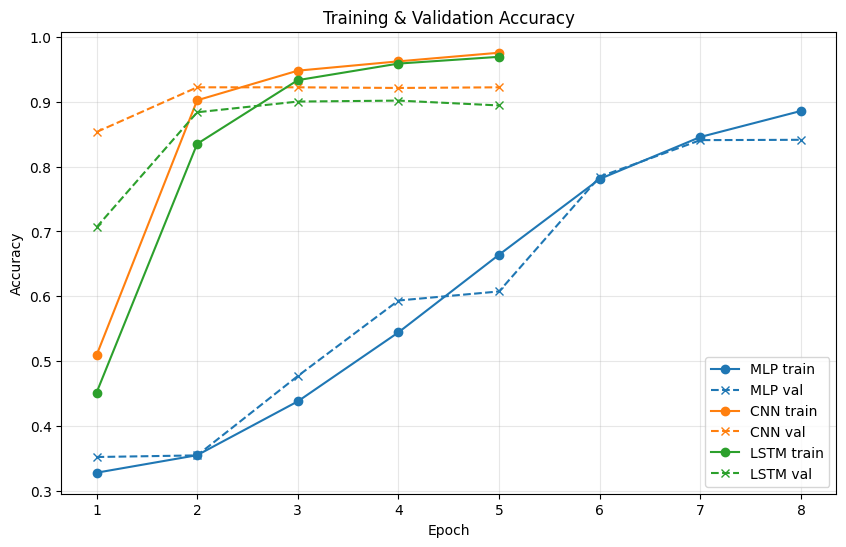

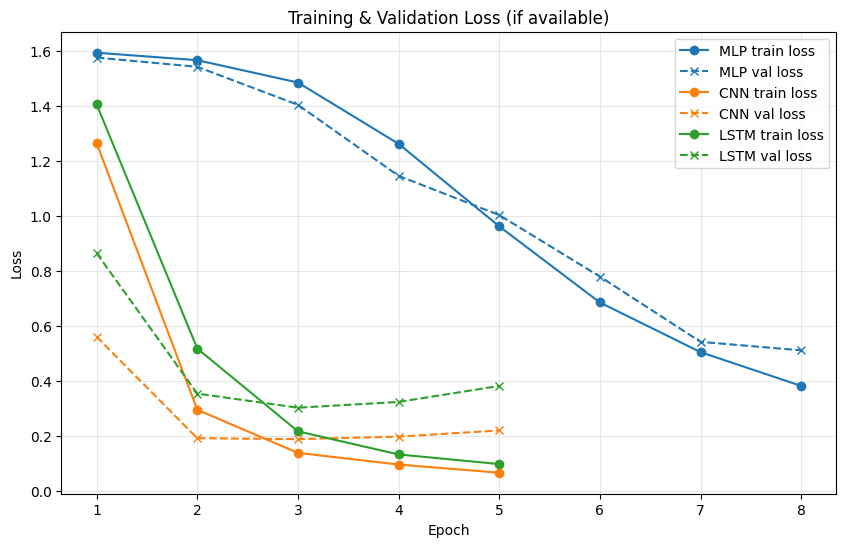

In [12]:
# Plot training & validation accuracy for MLP, CNN, LSTM
# This cell imports only what it needs and is robust to missing history variables.

import matplotlib.pyplot as plt

def _get_history_dict(possible_names, model_name):
    """
    Try to find a history dict for a model.
    possible_names: list of variable names to check in globals() (e.g. ['history_mlp','hist_mlp'])
    model_name: fallback model variable name (e.g. 'mlp') to see if model.history exists
    Returns: dict with keys like 'accuracy' and 'val_accuracy' or None
    """
    g = globals()
    # 1) Try explicit history variables
    for name in possible_names:
        if name in g:
            hist_obj = g[name]
            # If it's a keras History object, it has .history
            if hasattr(hist_obj, 'history'):
                return hist_obj.history
            # Or maybe user stored the dict directly
            if isinstance(hist_obj, dict):
                return hist_obj
    # 2) Try checking model.history if the user attached it (rare)
    if model_name in g:
        model_obj = g[model_name]
        # Some users do: model.history = history (non-standard), handle it
        if hasattr(model_obj, 'history'):
            mh = model_obj.history
            if hasattr(mh, 'history'):
                return mh.history
            if isinstance(mh, dict):
                return mh
    return None

# names to look for
histories = {
    'MLP': _get_history_dict(['history_mlp','hist_mlp','history_mlp_obj','historyMLP'], 'mlp'),
    'CNN': _get_history_dict(['history_cnn','hist_cnn','history_cnn_obj','historyCNN'], 'cnn'),
    'LSTM': _get_history_dict(['history_lstm','hist_lstm','history_lstm_obj','historyLSTM'], 'lstm')
}

# check what we found
found_any = any(v is not None for v in histories.values())

if not found_any:
    print("No training history objects found for MLP/CNN/LSTM.")
    print("If you trained models without saving the returned History, re-run training like this to capture history:")
    print("\nExample:")
    print("    history_mlp = mlp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)")
    print("    history_cnn = cnn.fit(...)")
    print("    history_lstm = lstm.fit(...)")
    print("\nThen run this plotting cell again. (If you did save them, ensure the variable names are `history_mlp`, `history_cnn`, `history_lstm`.)")
else:
    plt.figure(figsize=(10,6))
    colors = {'MLP':'tab:blue','CNN':'tab:orange','LSTM':'tab:green'}
    for model_name, hist in histories.items():
        if hist is None:
            continue
        # Accept both 'accuracy' (tf <2.3) or 'acc' older naming
        train_key = 'accuracy' if 'accuracy' in hist else ('acc' if 'acc' in hist else None)
        val_key   = 'val_accuracy' if 'val_accuracy' in hist else ('val_acc' if 'val_acc' in hist else None)
        if not train_key or not val_key:
            print(f"History for {model_name} found but does not contain accuracy keys. Keys available: {list(hist.keys())}")
            continue
        epochs = range(1, len(hist[train_key]) + 1)
        plt.plot(epochs, hist[train_key], marker='o', label=f"{model_name} train", color=colors.get(model_name))
        plt.plot(epochs, hist[val_key], marker='x', linestyle='--', label=f"{model_name} val", color=colors.get(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Optional: Also plot loss if available
    plt.figure(figsize=(10,6))
    for model_name, hist in histories.items():
        if hist is None:
            continue
        loss_key = 'loss'
        val_loss_key = 'val_loss'
        if loss_key in hist and val_loss_key in hist:
            epochs = range(1, len(hist[loss_key]) + 1)
            plt.plot(epochs, hist[loss_key], marker='o', label=f"{model_name} train loss", color=colors.get(model_name))
            plt.plot(epochs, hist[val_loss_key], marker='x', linestyle='--', label=f"{model_name} val loss", color=colors.get(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss (if available)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


#Performing EMOJI EMBEDDING
Overview of steps

Define emoji mapping for labels.

Build tokenized corpus where each sentence ends with its emoji-token.

Train Word2Vec (gensim).

Extract emoji vectors and inspect neighbors.

Visualize emoji + sample words in 2D (t-SNE).

Save embeddings to disk.





In [13]:
#Emoji mapping (adjust labels to your dataset labels)
# Import only what is needed here
label_to_emoji = {
    'joy': '😊',
    'sadness': '😢',
    'anger': '😡',
    'fear': '😨',
    'love': '😍',
    'surprise': '😲',
    'excitement': '🤩',
    'affection': '🥰',
    'thankful': '🙏',
    'disappointed': '😕',
    'scared': '😱',
    'anxious': '😰',
    'shame': '😳',
    'curious': '🤔',
    # add your dataset labels and emojis here
}

# Create token version for training (avoid raw emoji as token if you prefer readable token names)
# We'll keep both: raw emoji (for printing) and emoji_token (for training)
emoji_token_map = {}
for lab, emo in label_to_emoji.items():
    token = f"<EMO_{lab.upper()}>"
    emoji_token_map[lab] = {'emoji': emo, 'token': token}

emoji_token_map


{'joy': {'emoji': '😊', 'token': '<EMO_JOY>'},
 'sadness': {'emoji': '😢', 'token': '<EMO_SADNESS>'},
 'anger': {'emoji': '😡', 'token': '<EMO_ANGER>'},
 'fear': {'emoji': '😨', 'token': '<EMO_FEAR>'},
 'love': {'emoji': '😍', 'token': '<EMO_LOVE>'},
 'surprise': {'emoji': '😲', 'token': '<EMO_SURPRISE>'},
 'excitement': {'emoji': '🤩', 'token': '<EMO_EXCITEMENT>'},
 'affection': {'emoji': '🥰', 'token': '<EMO_AFFECTION>'},
 'thankful': {'emoji': '🙏', 'token': '<EMO_THANKFUL>'},
 'disappointed': {'emoji': '😕', 'token': '<EMO_DISAPPOINTED>'},
 'scared': {'emoji': '😱', 'token': '<EMO_SCARED>'},
 'anxious': {'emoji': '😰', 'token': '<EMO_ANXIOUS>'},
 'shame': {'emoji': '😳', 'token': '<EMO_SHAME>'},
 'curious': {'emoji': '🤔', 'token': '<EMO_CURIOUS>'}}

In [14]:
#build tokenized corpus
# Imports localized
import nltk
# if not already downloaded in your session
nltk.download('punkt')  # if not already downloaded in your session
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Use df_train (assumes you already loaded and cleaned df_train with column 'clean')
# If you didn't, ensure df_train exists from earlier steps; otherwise load dataset first.

def build_corpus_with_emojis(df, label_col='label', text_col='clean'):
    corpus = []
    missing = 0
    for _, row in df.iterrows():
        lab = row[label_col]
        text = row[text_col]
        if not isinstance(text, str) or text.strip() == "":
            continue
        # tokenize simple word tokenization
        tokens = word_tokenize(text.lower())
        if lab in emoji_token_map:
            tokens.append(emoji_token_map[lab]['token'])
        else:
            missing += 1
        corpus.append(tokens)
    if missing:
        print(f"Warning: {missing} rows had labels not in emoji map.")
    return corpus

corpus_train = build_corpus_with_emojis(df_train)   # uses your df_train from earlier
len(corpus_train), corpus_train[:3]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


(16000,
 [['i', 'didnt', 'feel', 'humiliated', '<EMO_SADNESS>'],
  ['i',
   'can',
   'go',
   'from',
   'feeling',
   'so',
   'hopeless',
   'to',
   'so',
   'damned',
   'hopeful',
   'just',
   'from',
   'being',
   'around',
   'someone',
   'who',
   'cares',
   'and',
   'is',
   'awake',
   '<EMO_SADNESS>'],
  ['im',
   'grabbing',
   'a',
   'minute',
   'to',
   'post',
   'i',
   'feel',
   'greedy',
   'wrong',
   '<EMO_ANGER>']])

In [15]:
# Train Word2Vec using gensim
!pip install -q gensim
from gensim.models import Word2Vec

# Model hyperparameters (you can tune)
EMBED_SIZE = 100
WINDOW = 5
MIN_COUNT = 2   # words with freq < MIN_COUNT ignored
WORKERS = 2

w2v = Word2Vec(
    sentences=corpus_train,
    vector_size=EMBED_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS,
    sg=1,           # skip-gram (sg=0 -> CBOW)
    epochs=10
)

# Save quick
w2v.save("word2vec_with_emoji.model")
print("Vocabulary size:", len(w2v.wv.index_to_key))
# Check emoji tokens exist
for lab, info in emoji_token_map.items():
    token = info['token']
    print(token, "in vocab? ", token in w2v.wv)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 73.5 MB/s eta 0:00:00
Vocabulary size: 7403
<EMO_JOY> in vocab?  True
<EMO_SADNESS> in vocab?  True
<EMO_ANGER> in vocab?  True
<EMO_FEAR> in vocab?  True
<EMO_LOVE> in vocab?  True
<EMO_SURPRISE> in vocab?  True
<EMO_EXCITEMENT> in vocab?  False
<EMO_AFFECTION> in vocab?  False
<EMO_THANKFUL> in vocab?  False
<EMO_DISAPPOINTED> in vocab?  False
<EMO_SCARED> in vocab?  False
<EMO_ANXIOUS> in vocab?  False
<EMO_SHAME> in vocab?  False
<EMO_CURIOUS> in vocab?  False


In [16]:
#Get emoji vectors and find nearest words
from pprint import pprint

def emoji_neighbors(model, topn=10):
    res = {}
    for lab, info in emoji_token_map.items():
        token = info['token']
        if token in model.wv:
            neighbors = model.wv.most_similar(token, topn=topn)
            res[lab] = {'token': token, 'emoji': info['emoji'], 'neighbors': neighbors}
        else:
            res[lab] = {'token': token, 'emoji': info['emoji'], 'neighbors': None}
    return res

neighbors = emoji_neighbors(w2v, topn=12)
pprint(neighbors)


{'affection': {'emoji': '🥰', 'neighbors': None, 'token': '<EMO_AFFECTION>'},
 'anger': {'emoji': '😡',
           'neighbors': [('either', 0.5175846815109253),
                         ('violent', 0.49533721804618835),
                         ('easily', 0.4865376651287079),
                         ('hateful', 0.4824693202972412),
                         ('mad', 0.4707668721675873),
                         ('deny', 0.46743044257164),
                         ('aint', 0.46041327714920044),
                         ('practically', 0.4603702425956726),
                         ('irrationally', 0.4599038362503052),
                         ('resentful', 0.45696789026260376),
                         ('weirdo', 0.4564640522003174),
                         ('worldly', 0.454521119594574)],
           'token': '<EMO_ANGER>'},
 'anxious': {'emoji': '😰', 'neighbors': None, 'token': '<EMO_ANXIOUS>'},
 'curious': {'emoji': '🤔', 'neighbors': None, 'token': '<EMO_CURIOUS>'},
 'disappointed': {'em

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


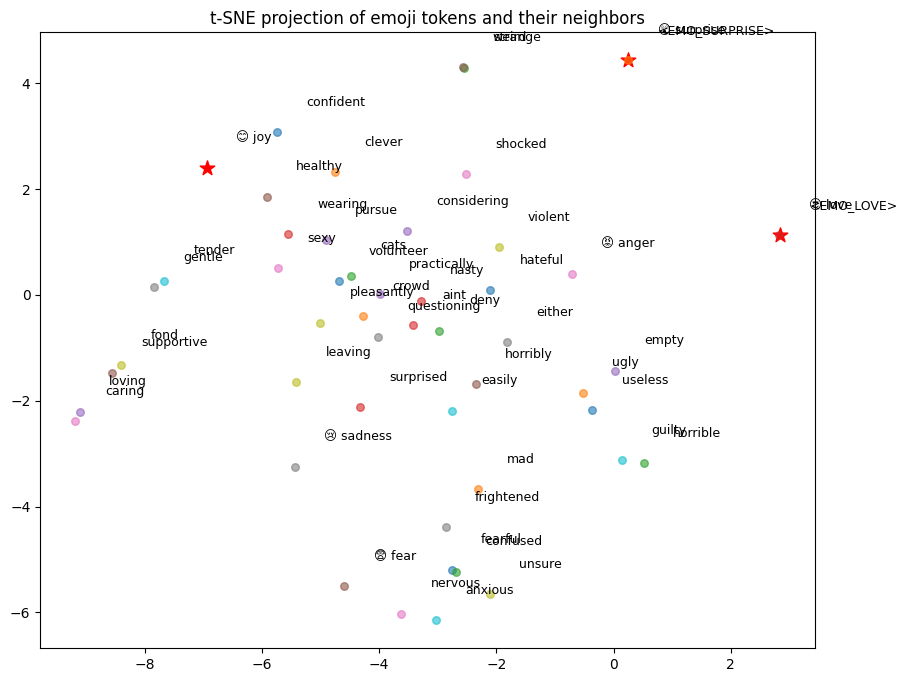

In [17]:
#Visualize emoji + neighbors using t-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# collect tokens to visualize: emoji tokens + their top neighbors
tokens_to_plot = []
labels_for_plot = []
for lab, info in neighbors.items():
    token = info['token']
    if info['neighbors'] is None:
        continue
    tokens_to_plot.append(token)
    labels_for_plot.append(info['emoji'] + " " + lab)
    for neigh, sim in info['neighbors'][:8]:  # top neighbors
        if neigh not in tokens_to_plot:
            tokens_to_plot.append(neigh)
            labels_for_plot.append(neigh)

# filter tokens that exist in vocab
tokens_to_plot = [t for t in tokens_to_plot if t in w2v.wv]
labels_for_plot = [labels_for_plot[i] for i, t in enumerate(tokens_to_plot)]

# build matrix
vecs = np.array([w2v.wv[t] for t in tokens_to_plot])

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
vecs_2d = tsne.fit_transform(vecs)

# plot
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(vecs_2d):
    lbl = labels_for_plot[i]
    if lbl.startswith('<EMO_') or lbl.startswith('😊') or lbl in [v['emoji'] for v in emoji_token_map.values()]:
        plt.scatter(x, y, s=120, marker='*', color='red')
    else:
        plt.scatter(x, y, s=30, alpha=0.6)
    plt.text(x+0.5, y+0.5, lbl, fontsize=9)
plt.title("t-SNE projection of emoji tokens and their neighbors")
plt.show()


In [18]:
# Save emoji vectors for later use
import numpy as np
import csv

emoji_vectors = {}
for lab, info in emoji_token_map.items():
    token = info['token']
    if token in w2v.wv:
        emoji_vectors[lab] = w2v.wv[token]
    else:
        emoji_vectors[lab] = None

# Save to npz
np.savez("emoji_embeddings.npz", **{k: v for k,v in emoji_vectors.items() if v is not None})
print("Saved emoji embeddings to emoji_embeddings.npz")

# optional CSV (label + emoji + vector as comma-separated)
with open("emoji_embeddings.csv", "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    header = ["label", "emoji"] + [f"dim{i}" for i in range(EMBED_SIZE)]
    writer.writerow(header)
    for lab, vec in emoji_vectors.items():
        if vec is None:
            continue
        row = [lab, emoji_token_map[lab]['emoji']] + vec.tolist()
        writer.writerow(row)
print("Saved emoji_embeddings.csv")


Saved emoji embeddings to emoji_embeddings.npz
Saved emoji_embeddings.csv


**using Hybrid models**

#TF-IDF weighted Word2Vec → Logistic Regression

In [19]:
# Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import joblib

# 1. Train (or load) Word2Vec on your cleaned tokenized corpus if you don't have w2v
# If you have trained w2v earlier and variable `w2v` exists, skip training and use it.
if 'w2v' not in globals():
    import nltk
    nltk.download('punkt')
    from nltk.tokenize import word_tokenize
    corpus = [word_tokenize(t.lower()) for t in df_train['clean'].tolist()]
    w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=2, sg=1, epochs=10)
    w2v.save("w2v_from_corpus.model")

# 2. TF-IDF (fit on train)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf_train = tfidf.fit_transform(df_train['clean'].tolist())
X_tfidf_val   = tfidf.transform(df_val['clean'].tolist())
X_tfidf_test  = tfidf.transform(df_test['clean'].tolist())

# helper: compute TF-IDF-weighted average Word2Vec vectors
vocab = tfidf.vocabulary_            # token -> index
idf = tfidf.idf_                     # idf array indexed by token index

def tfidf_w2v_features(texts, tfidf_vectorizer, w2v_model):
    fv = []
    vocab = tfidf_vectorizer.vocabulary_
    idf = tfidf_vectorizer.idf_
    for txt in texts:
        words = txt.split()
        vecs = []
        weights = []
        for w in words:
            if w in w2v_model.wv and w in vocab:
                w_idx = vocab[w]
                w_idf = idf[w_idx]
                vecs.append(w2v_model.wv[w] * w_idf)
                weights.append(w_idf)
        if len(vecs) > 0:
            fv.append(np.mean(vecs, axis=0))
        else:
            fv.append(np.zeros(w2v_model.vector_size))
    return np.array(fv)

Xw_train = tfidf_w2v_features(df_train['clean'].tolist(), tfidf, w2v)
Xw_val   = tfidf_w2v_features(df_val['clean'].tolist(), tfidf, w2v)
Xw_test  = tfidf_w2v_features(df_test['clean'].tolist(), tfidf, w2v)

# 3. Label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(df_train['label']) + list(df_val['label']) + list(df_test['label']))
y_train = le.transform(df_train['label'])
y_val   = le.transform(df_val['label'])
y_test  = le.transform(df_test['label'])

# 4. Train Logistic Regression on weighted W2V
clf_w2v = LogisticRegression(max_iter=300, random_state=42, multi_class='ovr')
clf_w2v.fit(Xw_train, y_train)

# Save artifacts
joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(clf_w2v, "clf_tfidf_w2v_lr.pkl")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


['clf_tfidf_w2v_lr.pkl']

#TF-IDF + BERT sentence embeddings → concatenate

In [20]:
# FAST replacement for Block 4: use sentence-transformers (all-MiniLM-L6-v2)
# Much faster than mean-pooling DistilBERT, and high quality sentence embeddings.
# Runs on CPU OK, much faster on GPU.

# 1) Install sentence-transformers (run once)
!pip install -q sentence-transformers

# 2) Fast compute + caching function
from sentence_transformers import SentenceTransformer
import numpy as np
from pathlib import Path
import torch

# Choose device: 'cuda' if available else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Small, fast model
SENT_MODEL = "all-MiniLM-L6-v2"   # small & fast; good quality
model_st = SentenceTransformer(SENT_MODEL, device=device)

def compute_fast_embeddings(texts, out_path, batch_size=64, force=False, show_progress=True):
    out_path = Path(out_path)
    if out_path.exists() and not force:
        print(f"Loading cached embeddings from {out_path}")
        return np.load(out_path)
    # sentence-transformers provides a fast .encode function
    embs = model_st.encode(texts, batch_size=batch_size, show_progress_bar=show_progress, device=device)
    embs = np.asarray(embs, dtype=np.float32)
    np.save(out_path, embs)
    print(f"Saved embeddings to {out_path} shape={embs.shape}")
    return embs

# 3) Run for train/val/test (adjust batch_size as needed)
Xbert_train = compute_fast_embeddings(df_train['clean'].tolist(), '/content/bert_emb_train_fast.npy', batch_size=64, force=False)
Xbert_val   = compute_fast_embeddings(df_val['clean'].tolist(),   '/content/bert_emb_val_fast.npy',   batch_size=64, force=False)
Xbert_test  = compute_fast_embeddings(df_test['clean'].tolist(),  '/content/bert_emb_test_fast.npy',  batch_size=64, force=False)

# 4) Quick shape check
print("Train emb shape:", Xbert_train.shape)
print("Val   emb shape:", Xbert_val.shape)
print("Test  emb shape:", Xbert_test.shape)


Using device: cuda


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Saved embeddings to /content/bert_emb_train_fast.npy shape=(16000, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved embeddings to /content/bert_emb_val_fast.npy shape=(2000, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved embeddings to /content/bert_emb_test_fast.npy shape=(2000, 384)
Train emb shape: (16000, 384)
Val   emb shape: (2000, 384)
Test  emb shape: (2000, 384)


#TF-IDF (SVD) + GloVe-initialized LSTM

In [21]:
# === TF-IDF (SVD) + GloVe-initialized LSTM ===
# This cell needs GloVe file (we'll download 100d glove from online)

!wget -q -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip glove.6B.100d.txt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# 1) Prepare TF-IDF + SVD (lower-dim dense)
tfidf3 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
Xtf_train = tfidf3.fit_transform(df_train['clean'])
Xtf_val   = tfidf3.transform(df_val['clean'])
Xtf_test  = tfidf3.transform(df_test['clean'])

svd3 = TruncatedSVD(n_components=50, random_state=42)
Xsvd_train = svd3.fit_transform(Xtf_train)
Xsvd_val   = svd3.transform(Xtf_val)
Xsvd_test  = svd3.transform(Xtf_test)

# 2) Tokenizer + sequences (for LSTM)
MAX_VOCAB = 20000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['clean'])
X_seq_train = tokenizer.texts_to_sequences(df_train['clean'])
X_seq_val   = tokenizer.texts_to_sequences(df_val['clean'])
X_seq_test  = tokenizer.texts_to_sequences(df_test['clean'])

X_seq_train = pad_sequences(X_seq_train, maxlen=MAX_LEN, padding='post')
X_seq_val   = pad_sequences(X_seq_val, maxlen=MAX_LEN, padding='post')
X_seq_test  = pad_sequences(X_seq_test, maxlen=MAX_LEN, padding='post')

# 3) Load GloVe vectors into embedding matrix
EMB_DIM = 100
emb_index = {}
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vec = np.asarray(parts[1:], dtype='float32')
        emb_index[word] = vec

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMB_DIM))
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    vec = emb_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

# 4) Build model: sequence input -> Embedding(GloVe) -> BiLSTM -> pooled -> concat with TFIDF-SVD -> Dense
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout, Concatenate

seq_in = Input(shape=(MAX_LEN,), name='seq_in')
x = Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False)(seq_in)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)

svd_in = Input(shape=(Xsvd_train.shape[1],), name='svd_in')

x = Concatenate()([x, svd_in])
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(len(set(df_train['label'])), activation='softmax')(x)

model_glove = Model(inputs=[seq_in, svd_in], outputs=out)
model_glove.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.summary()

# 5) Labels
le = LabelEncoder()
le.fit(list(df_train['label']) + list(df_val['label']) + list(df_test['label']))
y_train = le.transform(df_train['label'])
y_val   = le.transform(df_val['label'])
y_test  = le.transform(df_test['label'])

# 6) Train (with early stopping)
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_glove_lstm = model_glove.fit(
    {'seq_in': X_seq_train, 'svd_in': Xsvd_train},
    y_train,
    validation_data=({'seq_in': X_seq_val, 'svd_in': Xsvd_val}, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[es]
)

# 7) Evaluate
print("Validation (TFIDF+GloVe-LSTM):")
pred_val = model_glove.predict({'seq_in': X_seq_val, 'svd_in': Xsvd_val}).argmax(axis=1)
print(classification_report(y_val, pred_val, target_names=le.classes_))

print("Test (TFIDF+GloVe-LSTM):")
pred_test = model_glove.predict({'seq_in': X_seq_test, 'svd_in': Xsvd_test}).argmax(axis=1)
print(classification_report(y_test, pred_test, target_names=le.classes_))


Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 100)  │  1,521,300 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 256)  │    234,496 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ svd_in (InputLayer) │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 306)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ svd_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     39,296 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 6)         │        774 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,795,866 (6.85 MB)

 Trainable params: 274,566 (1.05 MB)

 Non-trainable params: 1,521,300 (5.80 MB)

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.4261 - loss: 1.4618 - val_accuracy: 0.7110 - val_loss: 0.7922
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7534 - loss: 0.7017 - val_accuracy: 0.8530 - val_loss: 0.4139
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8662 - loss: 0.3858 - val_accuracy: 0.8980 - val_loss: 0.2827
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9063 - loss: 0.2629 - val_accuracy: 0.9025 - val_loss: 0.2377
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9251 - loss: 0.2084 - val_accuracy: 0.9135 - val_loss: 0.2272
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9435 - loss: 0.1451 - val_accuracy: 0.9110 - val_loss: 0.2193
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9526 - loss: 0.1240 - val_accuracy: 0.9110 - val_loss: 0.2251
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9629 - loss: 0.0963 - val_acc

#classification reports

**TF-IDF + Word2Vec (Logistic Regression)**

In [22]:
#TF-IDF + Word2Vec (Logistic Regression)
try:
    y_true = y_test
    y_pred = clf_w2v.predict(Xw_test)

    print("📘  TF-IDF + Word2Vec (LR)  — Classification Report\n")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    plot_confusion_matrix(y_true, y_pred, le.classes_, "TF-IDF + Word2Vec (LR)")
except Exception as e:
    print("⚠️  Word2Vec model not available:", e)


📘  TF-IDF + Word2Vec (LR)  — Classification Report

              precision    recall  f1-score   support

       anger       0.75      0.63      0.68       275
        fear       0.75      0.64      0.69       224
         joy       0.77      0.89      0.83       695
        love       0.68      0.52      0.59       159
     sadness       0.79      0.84      0.81       581
    surprise       0.79      0.50      0.61        66

    accuracy                           0.77      2000
   macro avg       0.75      0.67      0.70      2000
weighted avg       0.77      0.77      0.76      2000

⚠️  Word2Vec model not available: name 'plot_confusion_matrix' is not defined


In [23]:
 #Evaluate
print("Validation Report (TFIDF+W2V -> LR):")
yv = clf_w2v.predict(Xw_val)
print(classification_report(y_val, yv, target_names=le.classes_))

Validation Report (TFIDF+W2V -> LR):
              precision    recall  f1-score   support

       anger       0.81      0.69      0.75       275
        fear       0.72      0.67      0.70       212
         joy       0.78      0.90      0.84       704
        love       0.81      0.56      0.66       178
     sadness       0.79      0.85      0.82       550
    surprise       0.73      0.41      0.52        81

    accuracy                           0.78      2000
   macro avg       0.77      0.68      0.71      2000
weighted avg       0.78      0.78      0.78      2000



***TF-IDF + BERT***

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

📘 Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.94      0.90      0.92       275
        fear       0.87      0.88      0.88       212
         joy       0.93      0.94      0.93       704
        love       0.85      0.84      0.85       178
     sadness       0.93      0.95      0.94       550
    surprise       0.89      0.84      0.87        81

    accuracy                           0.92      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.92      0.92      0.92      2000


📘 Test Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.90      0.92       275
        fear       0.89      0.89      0.89       224
         joy       0.91      0.95      0.93       695
        love       0.85      0.79      0.82       159
     sadness       0.96      0.96      0

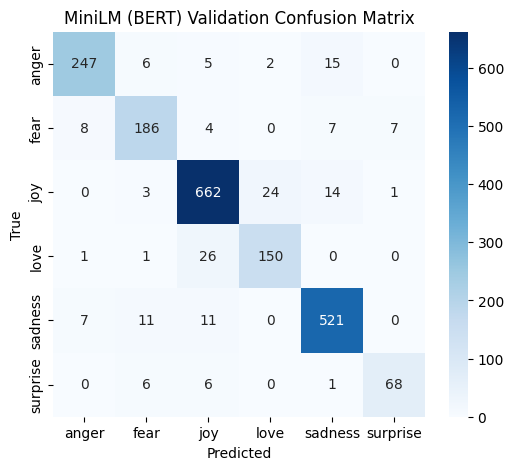

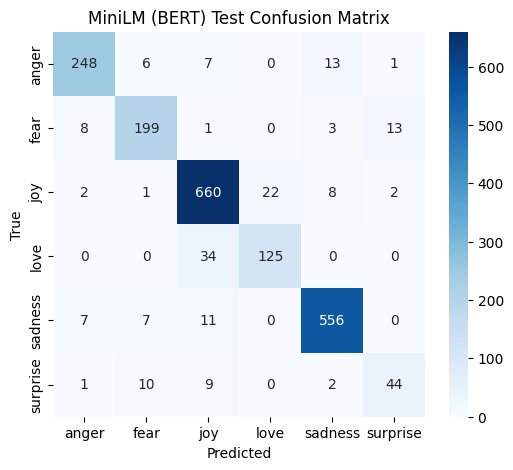

In [24]:
# Block 3: classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for validation and test sets
val_pred = model_glove.predict({'seq_in': X_seq_val, 'svd_in': Xsvd_val}).argmax(axis=1)
test_pred = model_glove.predict({'seq_in': X_seq_test, 'svd_in': Xsvd_test}).argmax(axis=1)


print("\n📘 Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

print("\n📘 Test Classification Report:")
print(classification_report(y_test, test_pred, target_names=le.classes_))

# Confusion Matrix Plot Function
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(y_val, val_pred, le.classes_, "MiniLM (BERT) Validation Confusion Matrix")
plot_cm(y_test, test_pred, le.classes_, "MiniLM (BERT) Test Confusion Matrix")

**TF-IDF + GloVe-LSTM**

In [25]:
# Block 4: TF-IDF + GloVe-LSTM
try:
    y_true = y_test
    y_pred = model_glove.predict({'seq_in': X_seq_test, 'svd_in': Xsvd_test}).argmax(axis=1)

    print("🧠  TF-IDF + GloVe-LSTM  — Classification Report\n")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    plot_confusion_matrix(y_true, y_pred, le.classes_, "TF-IDF + GloVe-LSTM")
except Exception as e:
    print("⚠️  TF-IDF + GloVe-LSTM model not available:", e)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
🧠  TF-IDF + GloVe-LSTM  — Classification Report

              precision    recall  f1-score   support

       anger       0.93      0.90      0.92       275
        fear       0.89      0.89      0.89       224
         joy       0.91      0.95      0.93       695
        love       0.85      0.79      0.82       159
     sadness       0.96      0.96      0.96       581
    surprise       0.73      0.67      0.70        66

    accuracy                           0.92      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000

⚠️  TF-IDF + GloVe-LSTM model not available: name 'plot_confusion_matrix' is not defined


#BERT+LSTM

Using device: cuda model: all-MiniLM-L6-v2


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Saved embeddings to /content/st_train.npy shape= (16000, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved embeddings to /content/st_val.npy shape= (2000, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved embeddings to /content/st_test.npy shape= (2000, 384)
Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise'] Num classes: 6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,230 (516.52 KB)

 Trainable params: 132,230 (516.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4832 - loss: 1.3747 - val_accuracy: 0.6480 - val_loss: 0.9291
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6582 - loss: 0.9402 - val_accuracy: 0.6860 - val_loss: 0.8373
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6998 - loss: 0.8337 - val_accuracy: 0.7105 - val_loss: 0.7941
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7212 - loss: 0.7552 - val_accuracy: 0.7215 - val_loss: 0.7651
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7494 - loss: 0.6892 - val_accuracy: 0.7230 - val_loss: 0.7421
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7749 - loss: 0.6324 - val_accuracy: 0.7280 - val_loss: 0.7428
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7878 - loss: 0.5871 - val_accuracy: 0.7320 - val_loss: 0.7439
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Validation classification

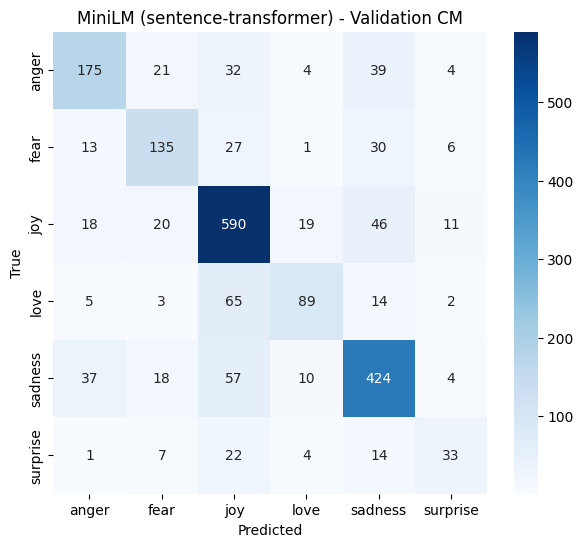

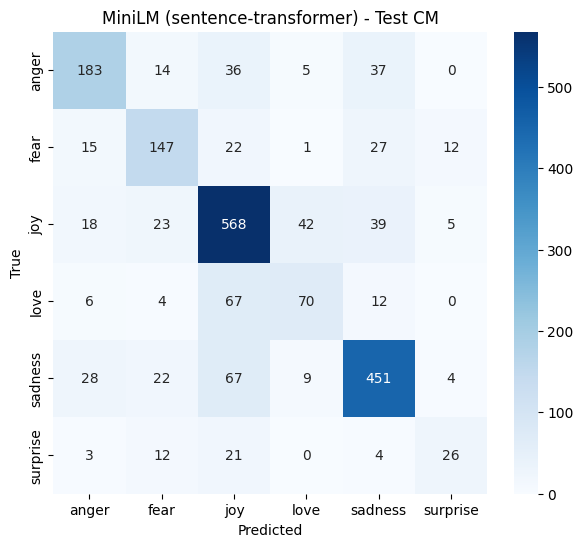

In [26]:
# Use sentence-transformers embeddings (MiniLM) + MLP classifier
# Run this cell after you have df_train, df_val, df_test with 'clean' and 'label' columns

!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# 1) compute embeddings (cached)
model_name = "all-MiniLM-L6-v2"
device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
print("Using device:", device, "model:", model_name)
st = SentenceTransformer(model_name, device=device)

def compute_and_cache(path, texts, batch_size=64):
    import os
    if os.path.exists(path):
        print("Loading cached:", path)
        return np.load(path)
    embs = st.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    np.save(path, embs)
    print("Saved embeddings to", path, "shape=", embs.shape)
    return embs

X_train = compute_and_cache('/content/st_train.npy', df_train['clean'].tolist(), batch_size=64)
X_val   = compute_and_cache('/content/st_val.npy',   df_val['clean'].tolist(),   batch_size=64)
X_test  = compute_and_cache('/content/st_test.npy',  df_test['clean'].tolist(),  batch_size=64)

# 2) labels
le = LabelEncoder()
le.fit(list(df_train['label']) + list(df_val['label']) + list(df_test['label']))
y_train = le.transform(df_train['label'])
y_val   = le.transform(df_val['label'])
y_test  = le.transform(df_test['label'])
num_classes = len(le.classes_)
print("Classes:", le.classes_, "Num classes:", num_classes)

# 3) build a small classifier (MLP)
tf.random.set_seed(42)
input_dim = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 4) train
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=12, batch_size=64, callbacks=[es])

# 5) evaluate & confusion matrices
y_val_pred = model.predict(X_val).argmax(axis=1)
y_test_pred = model.predict(X_test).argmax(axis=1)

print("\nValidation classification report:\n")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
print("\nTest classification report:\n")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(y_val, y_val_pred, le.classes_, "MiniLM (sentence-transformer) - Validation CM")
plot_cm(y_test, y_test_pred, le.classes_, "MiniLM (sentence-transformer) - Test CM")


In [27]:
#Install libraries (run once)
!pip install -q transformers datasets torch torchvision torchaudio


In [28]:
# imports and device
import os, random, time
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [29]:
#settings and tokenizer
MODEL_NAME = "distilbert-base-uncased"   # change if you prefer full BERT
MAX_LEN = 96
BATCH_SIZE = 16
EPOCHS = 4
FREEZE_BERT = True   # set False to fine-tune BERT
LR = 2e-5

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded:", MODEL_NAME)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded: distilbert-base-uncased


In [30]:
#prepare datasets and dataloaders
from torch.utils.data import Dataset, DataLoader

# Ensure df_train, df_val, df_test exist and have 'clean' and 'label' columns
texts_train = df_train['clean'].astype(str).tolist()
texts_val   = df_val['clean'].astype(str).tolist()
texts_test  = df_test['clean'].astype(str).tolist()

le = LabelEncoder()
le.fit(list(df_train['label']) + list(df_val['label']) + list(df_test['label']))
y_train = le.transform(df_train['label'])
y_val   = le.transform(df_val['label'])
y_test  = le.transform(df_test['label'])
num_labels = len(le.classes_)
print("Classes:", le.classes_, "Num:", num_labels)

class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        txt = self.texts[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0)
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

ds_train = TextDataset(texts_train, y_train, tokenizer, MAX_LEN)
ds_val   = TextDataset(texts_val,   y_val,   tokenizer, MAX_LEN)
ds_test  = TextDataset(texts_test,  y_test,  tokenizer, MAX_LEN)

loader_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
loader_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
loader_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Batches — train:", len(loader_train), "val:", len(loader_val), "test:", len(loader_test))


Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise'] Num: 6
Batches — train: 1000 val: 125 test: 125


In [31]:
#model definition
import torch.nn as nn

class BertBiLSTM(nn.Module):
    def __init__(self, model_name, lstm_hidden=128, lstm_layers=1, dropout=0.3, num_labels=num_labels, freeze_bert=FREEZE_BERT):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        hidden_size = self.bert.config.hidden_size  # e.g., 768 for BERT, 768 for DistilBERT
        self.bilstm = nn.LSTM(input_size=hidden_size, hidden_size=lstm_hidden, num_layers=lstm_layers,
                              batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # global max pooling on sequence dim
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden*2, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_labels)
        )
    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # bert_out.last_hidden_state shape: (batch, seq_len, hidden)
        seq_embed = bert_out.last_hidden_state
        lstm_out, _ = self.bilstm(seq_embed)   # (batch, seq_len, 2*lstm_hidden)
        # transpose for pooling: (batch, features, seq_len)
        x = lstm_out.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)  # (batch, 2*lstm_hidden)
        logits = self.fc(x)
        return logits

model = BertBiLSTM(MODEL_NAME, lstm_hidden=128, lstm_layers=1, dropout=0.3, num_labels=num_labels, freeze_bert=FREEZE_BERT)
model.to(device)
print(model)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BertBiLSTM(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [32]:
#training loop
from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_model_path = "/content/best_bert_bilstm.pt"

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader_train, desc=f"Epoch {epoch} train")
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": total_loss / (pbar.n + 1)})
    avg_train_loss = total_loss / len(loader_train)
    # Validation
    model.eval()
    val_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader_val:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            preds.append(torch.argmax(logits, dim=1).cpu().numpy())
            trues.append(labels.cpu().numpy())
    avg_val_loss = val_loss / len(loader_val)
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    print(f"Epoch {epoch} — train_loss: {avg_train_loss:.4f} val_loss: {avg_val_loss:.4f}")
    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")


Epoch 1 train: 100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s, loss=1.57]


Epoch 1 — train_loss: 1.5658 val_loss: 1.4233
Saved best model.


Epoch 2 train: 100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s, loss=1.34]


Epoch 2 — train_loss: 1.3347 val_loss: 1.2438
Saved best model.


Epoch 3 train: 100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s, loss=1.25]


Epoch 3 — train_loss: 1.2453 val_loss: 1.1779
Saved best model.


Epoch 4 train: 100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s, loss=1.18]


Epoch 4 — train_loss: 1.1806 val_loss: 1.1170
Saved best model.


Validation Classification Report:

              precision    recall  f1-score   support

       anger       0.62      0.16      0.25       275
        fear       0.53      0.33      0.41       212
         joy       0.66      0.86      0.75       704
        love       0.00      0.00      0.00       178
     sadness       0.53      0.83      0.65       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.59      2000
   macro avg       0.39      0.37      0.34      2000
weighted avg       0.52      0.59      0.52      2000

Test Classification Report:

              precision    recall  f1-score   support

       anger       0.67      0.14      0.23       275
        fear       0.57      0.32      0.41       224
         joy       0.67      0.89      0.76       695
        love       0.00      0.00      0.00       159
     sadness       0.54      0.82      0.65       581
    surprise       0.00      0.00      0.00        66

    accuracy 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

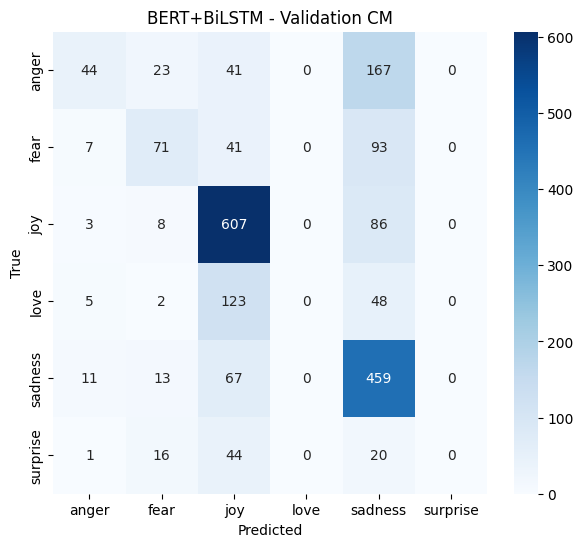

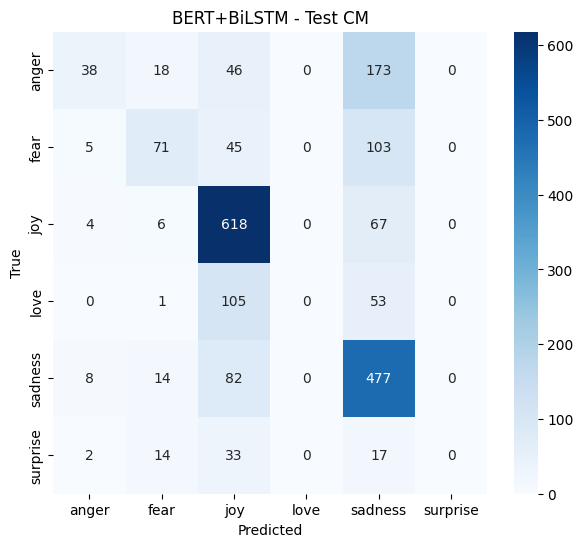

In [33]:
#load best model and evaluate
model.load_state_dict(torch.load("/content/best_bert_bilstm.pt"))
model.to(device)
model.eval()

def predict_loader(dl):
    preds = []
    trues = []
    with torch.no_grad():
        for batch in dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch.get('labels')
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.append(torch.argmax(logits, dim=1).cpu().numpy())
            if labels is not None:
                trues.append(labels.numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues) if len(trues)>0 else None
    return preds, trues

val_preds, val_trues = predict_loader(loader_val)
test_preds, test_trues = predict_loader(loader_test)

print("Validation Classification Report:\n")
print(classification_report(val_trues, val_preds, target_names=le.classes_))
print("Test Classification Report:\n")
print(classification_report(test_trues, test_preds, target_names=le.classes_))

# Confusion matrices
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(val_trues, val_preds, le.classes_, "BERT+BiLSTM - Validation CM")
plot_cm(test_trues, test_preds, le.classes_, "BERT+BiLSTM - Test CM")


In [34]:
#  save tokenizer and label encoder for inference
tokenizer.save_pretrained('/content/bert_tokenizer/')
import joblib
joblib.dump(le, '/content/label_encoder.joblib')
print("Saved tokenizer and label encoder.")


Saved tokenizer and label encoder.


In [ ]:
import re, unicodedata, numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- cleaning (same style as your training) ---
def clean_text_for_infer(s):
    if not isinstance(s, str): return ""
    s = unicodedata.normalize('NFKC', s)
    s = s.lower()
    s = re.sub(r'http\S+|www\.\S+', ' ', s)
    s = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' ', s)
    s = re.sub(r'\+?\d[\d -]{8,}\d', ' ', s)
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# --- use existing emoji mapping from session (no redefinition) ---
def emoji_of(label):
    if 'label_to_emoji' in globals() and isinstance(label_to_emoji, dict):
        return label_to_emoji.get(label, "❓")
    return "❓"

# --- helper: nearest emoji by Word2Vec (if present) ---
def nearest_emoji_by_embedding_local(text, topk=3):
    if 'w2v' not in globals():
        return None
    toks = [t for t in re.findall(r'\w+', text.lower()) if t in w2v.wv]
    if not toks:
        return None
    avg = np.mean([w2v.wv[t] for t in toks], axis=0)
    candidates = {}
    if 'emoji_token_map' in globals():
        for lab, info in emoji_token_map.items():
            tok = None
            if isinstance(info, list) and info:
                tok = info[0].get('token')
            elif isinstance(info, dict):
                tok = info.get('token')
            if tok and tok in w2v.wv:
                candidates[lab] = w2v.wv[tok]
    if not candidates and 'emoji_vectors' in globals():
        for lab, vec in emoji_vectors.items():
            if vec is not None:
                candidates[lab] = vec
    if not candidates:
        return None
    def cos(a,b):
        na, nb = np.linalg.norm(a), np.linalg.norm(b)
        if na==0 or nb==0: return -1
        return float(np.dot(a,b)/(na*nb))
    sims = sorted(((lab, cos(avg, vec)) for lab,vec in candidates.items()), key=lambda x: x[1], reverse=True)[:topk]
    return [(lab, emoji_of(lab), float(score)) for lab, score in sims]

# --- single-sentence inference orchestration ---
def infer_sentence(sentence, verbose=True):
    sent = sentence.strip()
    clean = clean_text_for_infer(sent)
    out = {'input': sent, 'clean': clean, 'predictions': {}}

    # 1) TF-IDF + LogisticRegression
    if 'model_lr' in globals() and 'tfidf' in globals() and 'le' in globals():
        try:
            x = tfidf.transform([clean])
            if hasattr(model_lr, 'predict_proba'):
                probs = model_lr.predict_proba(x)[0]
                pred_idx = int(model_lr.predict(x)[0])
                conf = float(probs.max())
            else:
                pred_idx = int(model_lr.predict(x)[0]); conf = None
            label = le.inverse_transform([pred_idx])[0]
            out['predictions']['tfidf_lr'] = {'label': label, 'emoji': emoji_of(label), 'conf': conf}
        except Exception as e:
            out['predictions']['tfidf_lr'] = {'error': str(e)}
    # 2) TF-IDF-weighted Word2Vec + LR (clf_w2v)
    if 'clf_w2v' in globals() and 'w2v' in globals() and 'tfidf' in globals():
        try:
            toks = [t for t in re.findall(r'\w+', clean) if t in w2v.wv]
            vocab = getattr(tfidf, "vocabulary_", {})
            idf = getattr(tfidf, "idf_", None)
            vecs = []
            for w in toks:
                if w in vocab and w in w2v.wv:
                    idx = vocab[w]
                    weight = (idf[idx] if idf is not None and idx < len(idf) else 1.0)
                    vecs.append(w2v.wv[w] * weight)
            feat = np.mean(vecs, axis=0) if len(vecs)>0 else np.zeros(w2v.vector_size)
            pred_idx = int(clf_w2v.predict([feat])[0])
            conf = float(clf_w2v.predict_proba([feat])[0].max()) if hasattr(clf_w2v, 'predict_proba') else None
            label = le.inverse_transform([pred_idx])[0]
            out['predictions']['tfidf_w2v'] = {'label': label, 'emoji': emoji_of(label), 'conf': conf}
        except Exception as e:
            out['predictions']['tfidf_w2v'] = {'error': str(e)}

    # 3) Keras deep models using tokenizer + MAX_LEN
    if 'tokenizer' in globals() and 'MAX_LEN' in globals():
        try:
            seq = pad_sequences(tokenizer.texts_to_sequences([clean]), maxlen=MAX_LEN, padding='post')
            for name in ('mlp','cnn','lstm'):
                if name in globals():
                    try:
                        m = globals()[name]
                        p = m.predict(seq, verbose=0)[0]
                        idx = int(np.argmax(p)); conf = float(p.max()); label = le.inverse_transform([idx])[0]
                        out['predictions'][name] = {'label': label, 'emoji': emoji_of(label), 'conf': conf}
                    except Exception as e:
                        out['predictions'][name] = {'error': str(e)}
        except Exception as e:
            out['predictions']['keras_tokenizer_error'] = {'error': str(e)}

    # 4) GloVe-LSTM or hybrid model_glove
    if 'model_glove' in globals():
        try:
            seq = pad_sequences(tokenizer.texts_to_sequences([clean]), maxlen=MAX_LEN, padding='post')
            # try single input, else dict
            try:
                p = model_glove.predict(seq, verbose=0)[0]
            except Exception:
                p = model_glove.predict({'seq_in': seq, 'svd_in': np.zeros((1, model_glove.input_shape[1]))}, verbose=0)[0]
            idx = int(np.argmax(p)); conf = float(p.max()); label = le.inverse_transform([idx])[0]
            out['predictions']['glove_lstm'] = {'label': label, 'emoji': emoji_of(label), 'conf': conf}
        except Exception as e:
            out['predictions']['glove_lstm'] = {'error': str(e)}

    # 5) Sentence-transformer + classifier
    if 'model_st' in globals():
        try:
            vec = model_st.encode([clean], convert_to_numpy=True)
            if 'mlp' in globals():
                p = mlp.predict(vec, verbose=0)[0]; idx = int(np.argmax(p)); conf = float(p.max()); label = le.inverse_transform([idx])[0]
                out['predictions']['st_mlp'] = {'label': label, 'emoji': emoji_of(label), 'conf': conf}
            elif 'clf_bert' in globals():
                pred = clf_bert.predict(vec)[0]; label = le.inverse_transform([pred])[0]
                out['predictions']['st_sklearn'] = {'label': label, 'emoji': emoji_of(label)}
            else:
                out['predictions']['st'] = {'note': 'no classifier found'}
        except Exception as e:
            out['predictions']['st'] = {'error': str(e)}

    # 6) PyTorch BERT+BiLSTM (if available)
    if 'model' in globals() and 'tokenizer' in globals():
        try:
            import torch
            enc = tokenizer(clean, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')
            device = next(model.parameters()).device
            ids = enc['input_ids'].to(device); am = enc['attention_mask'].to(device)
            model.eval()
            with torch.no_grad():
                logits = model(input_ids=ids, attention_mask=am)
                if isinstance(logits, tuple): logits = logits[0]
                preds = torch.argmax(logits, dim=1).cpu().numpy()
            label = le.inverse_transform([int(preds[0])])[0]
            out['predictions']['pytorch_bert_bilstm'] = {'label': label, 'emoji': emoji_of(label)}
        except Exception as e:
            out['predictions']['pytorch_bert_bilstm'] = {'error': str(e)}

    # 7) Embedding nearest emojis (Word2Vec)
    emb_nei = None
    try:
        emb_nei = nearest_emoji_by_embedding_local(clean, topk=3)
        if emb_nei:
            out['embedding_nearest'] = emb_nei
    except Exception:
        out['embedding_nearest'] = None

    # --- Ensemble decision (simple): prefer highest-confidence (if available), else majority vote, else embedding nearest
    final = None
    conf_list = []
    for k,v in out['predictions'].items():
        if isinstance(v, dict) and v.get('conf') is not None:
            try:
                conf_list.append((k, v['label'], float(v['conf'])))
            except Exception:
                pass
    if conf_list:
        best = max(conf_list, key=lambda x: x[2])
        final = {'method': best[0], 'label': best[1], 'emoji': emoji_of(best[1]), 'confidence': best[2]}
    else:
        # majority vote on available labels
        labels = [v['label'] for v in out['predictions'].values() if isinstance(v, dict) and 'label' in v]
        if labels:
            from collections import Counter
            lab, cnt = Counter(labels).most_common(1)[0]
            final = {'method': 'majority_vote', 'label': lab, 'emoji': emoji_of(lab), 'count': cnt}
        elif emb_nei:
            lab, emo, score = emb_nei[0]
            final = {'method': 'embedding_nearest', 'label': lab, 'emoji': emo, 'score': score}
        else:
            final = {'method': 'none', 'label': None, 'emoji': '❓'}

    out['final'] = final

    if verbose:
        print("\n---- per-model results ----")
        for k,v in out['predictions'].items():
            print(f"{k:<22} : {v}")
        if 'embedding_nearest' in out:
            print("embedding_nearest : ", out['embedding_nearest'])
        print("\nFINAL SUGGESTION :", final)

    return out

# ===== Interactive loop =====
print("Interactive Text→Emoji demo.")
print("Type a sentence and press Enter to get predictions.")
print("Special commands: ")
print("  file  -> run all lines from /mnt/data/test.txt")
print("  exit  -> quit\n")

while True:
    s = input("Enter sentence (or 'file' / 'exit'): ").strip()
    if not s:
        continue
    if s.lower() in ('exit','quit'):
        print("Exiting.")
        break
    if s.lower() == 'file':
        path = "/mnt/data/test.txt"
        if not os.path.exists(path):
            print("Test file not found at", path)
            continue
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        print(f"Running inference on {len(lines)} lines from {path}...\n")
        for ln in lines:
            infer_sentence(ln)
        print("\nDone file predictions.")
        continue
    # normal single sentence
    infer_sentence(s)
    print("\n--- next ---\n")


Interactive Text→Emoji demo.
Type a sentence and press Enter to get predictions.
Special commands: 
  file  -> run all lines from /mnt/data/test.txt
  exit  -> quit

Enter sentence (or 'file' / 'exit'): ferrocious

---- per-model results ----
tfidf_lr               : {'error': 'X has 10000 features, but LogisticRegression is expecting 5000 features as input.'}
tfidf_w2v              : {'label': np.str_('joy'), 'emoji': '😊', 'conf': 0.8417461112925585}
keras_tokenizer_error  : {'error': 'DistilBertTokenizerFast has no attribute texts_to_sequences'}
glove_lstm             : {'error': 'DistilBertTokenizerFast has no attribute texts_to_sequences'}
st                     : {'error': 'Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 80), found shape=(1, 384)'}
pytorch_bert_bilstm    : {'label': np.str_('joy'), 'emoji': '😊'}

FINAL SUGGESTION : {'method': 'tfidf_w2v', 'label': np.str_('joy'), 'emoji': '😊', 'confidence': 0.8417461112925585}

--- next ---

Ent